In [1]:
import black
import re
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UGate
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display


In [2]:
# Example generated circuit code
generated_code = ( "qc = QuantumCircuit(3, 3)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "## Begin Oracle\n" "qc.z(1)\n" "## End Oracle\n" "## Begin Diffuser\n" "qc.cx(0,1)\n" "## End Diffuser\n" "qc.measure(0, 0)\n" "qc.measure(1, 1)\n" "qc.measure(2, 2)\n"
)
cleaned_code = black.format_str(generated_code, mode=black.Mode())
print("=== Final Code String (Black-Formatted) ===\n")
print(cleaned_code)


=== Final Code String (Black-Formatted) ===

qc = QuantumCircuit(3, 3)
qc.h(0)
qc.h(1)
qc.h(2)
## Begin Oracle
qc.z(1)
## End Oracle
## Begin Diffuser
qc.cx(0, 1)
## End Diffuser
qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)




Circuit successfully created:


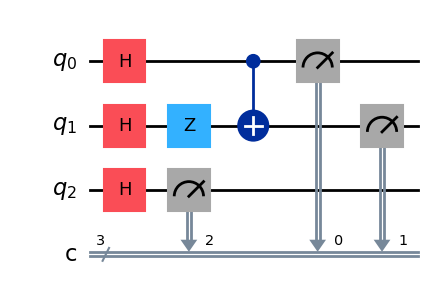

In [3]:
# Define a minimal set of globals so the generated code can use QuantumCircuit
allowed_globals = {
    "QuantumCircuit": QuantumCircuit,
}
# Prepare a local dictionary where the code will run
local_dict = {}

# Execute the code string
exec(cleaned_code, allowed_globals, local_dict)

# Retrieve the 'qc' object from the local dictionary
qc_test = local_dict.get("qc", None)

if qc_test is None:
    print("\n[Decode Error] 'qc' was not created by the generated code.")
else:
    print("\nCircuit successfully created:")
    display(qc_test.draw("mpl"))



Counts: {'000': 124, '010': 118, '101': 125, '111': 137, '011': 109, '001': 120, '100': 146, '110': 145}


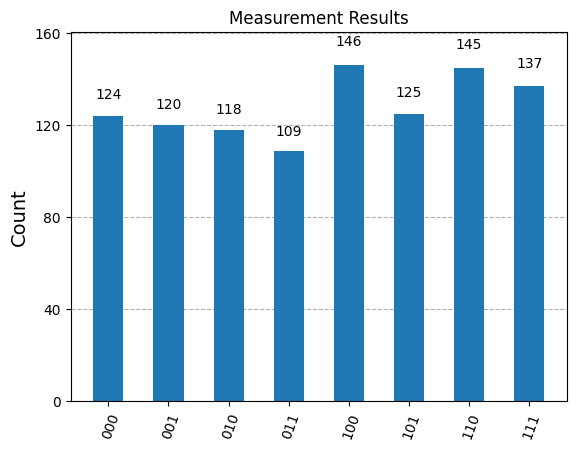

In [4]:
if qc_test:
    simulator = QasmSimulator()
    compiled_circuit = transpile(qc_test, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()
    print("\nCounts:", counts)
    display(plot_histogram(counts, title="Measurement Results"))

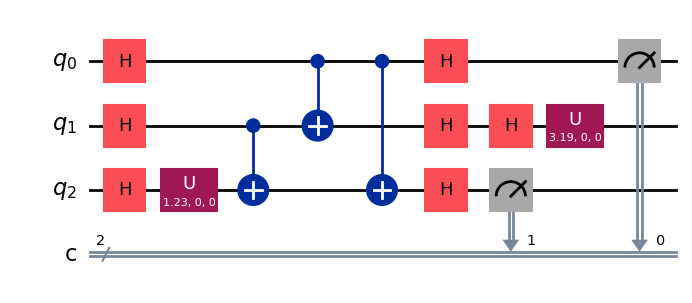

In [5]:
qc = QuantumCircuit(3, 2)  # 3 qubits, 2 classical bits for measurement

# Apply Hadamard gates
qc.h([0, 1, 2])

# Define M1 unitary transformations
qc.append(UGate(1.234, 0, 0), [2])
qc.cx(1, 2)
qc.cx(0, 1)

# Function f operation (assuming a controlled operation)
qc.cx(0, 2)

# Apply Hadamard gates after function evaluation
qc.h([0, 1, 2])

# Define M2 unitary transformations
qc.h(1)
qc.append(UGate(3.1929, 0, 0), [1])

# Measurement
qc.measure(0, 0)
qc.measure(2, 1)

# Draw the circuit
qc.draw('mpl')
